# MNIST数据集

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
# keys()函数返回字典所有键
mnist.keys()
#data包含一个数组，每个实例为一行，每个特征为一列
#target包含一个代标记的数组

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print('X的形状为', X.shape)
print('y的形状为', y.shape)
"""
从X的形状可以看出，有70000个数据，每张图片有784个特征
"""
print(type(X)) #数组为DataFrame

X的形状为 (70000, 784)
y的形状为 (70000,)
<class 'pandas.core.frame.DataFrame'>


#### tips：取DataFrame特定列

####

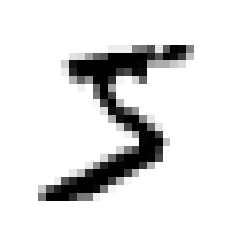

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#选取X数组中的第一行
some_digit = X.iloc[0]
#因为DAtaFrame格式不提供reshape，所以taFrame格式不提供reshape，所以用values.reshape()函数重新转换格式,且转换之后的格式为numpy数组
some_digit_image = some_digit.values.reshape(28, 28)  #<class 'numpy.ndarray'>
#print(type(some_digit_image))
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0] #此时可以看见图片像是5，而标签确实是5,但是标签是字符，要转换为整数
import numpy as np
y = y.astype(np.uint8)

## 划分测试集和训练集

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 训练二元分类器

In [6]:
"""
只尝试识别数字5
"""
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [33]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
print(sgd_clf.classes_)

[False  True]


In [8]:
sgd_clf.predict([some_digit])

array([ True])

### 性能测量

#### 使用交叉验证测量准确率

In [9]:
# k折交叉验证法
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
# 蠢笨分类器(将每张图片看作非5)
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [11]:
# 测试蠢笨分类器准确率
never_5_clf = Never5Classifier()
print(X_train.shape)
print(y_train_5.shape)
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

(60000, 784)
(60000,)


array([0.91125, 0.90855, 0.90915])

#### 混淆矩阵
sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
y_true：真实因变量值
y_pred：预测因变量值
labels：矩阵的标签列表索引顺序
sample_weight：样本权重

In [17]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict返回的是每一折的预测
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred)

[ True False False ...  True False False]


In [15]:
"""
混淆矩阵:混淆矩阵是机器学习中总结分类模型预测结果的情形分析表，以矩阵形式将数据集中的记录按照真实的类别与分类模型作出的分类判断两个标准进行汇总。
行表示实际类别，列表示预测类别
下面矩阵中，第一行表示所有“非5”（负类）的图片中：53892张照片被判断为“非5”（真负类），687张照片被分类成“5”（假正类）
第二行表示所有“5”（正类）的图片中：1891张照片被错误的分为“非5”（假负类），3530张照片被正确分类成“5”（真正类）
真负类TN     假正类FP
假负类FN     真正类TP
"""
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
y_train_perfect_perdictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_perdictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### 精度和召回率

In [18]:
from sklearn.metrics import recall_score, precision_score

precision_score(y_train_5, y_train_pred) # == 3530 / 3530 + 687

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred) # == 3530 / 3530 + 1891
# 以上结果说明当一张图片是5时，只有83.7%的概率是准确的，并且也只有65%的数字5被检测出来了

0.6511713705958311

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) # == 3530 /（3530 + （1891 + 687） / 2）

0.7325171197343846

#### 精度/召回率权衡

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threhold = 0 #设置精度/召回率阈值
y_some_digit_pred = (y_scores > threhold)
y_some_digit_pred
# 因为阈值为0，所以与前面predict()方法返回值相同

array([ True])

In [27]:
threhold = 8000
y_some_digit_pred = (y_scores > threhold)
y_some_digit_pred

array([False])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [35]:
from sklearn.metrics import precision_recall_curve
# precision_recall_curve（）：计算所有可能的阈值的精度和召回率
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

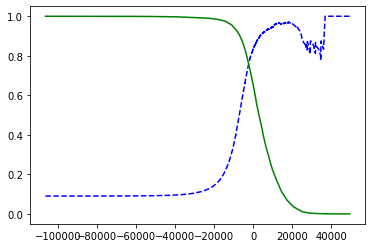

In [43]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [38]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [41]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [42]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

#### ROC曲线

In [45]:
from sklearn.metrics import roc_curve
# roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)
#返回三个参数
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

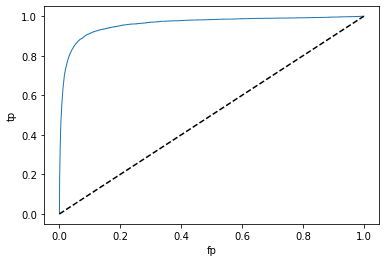

In [50]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=1, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('fp')
    plt.ylabel('tp')
plot_roc_curve(fpr, tpr)
plt.show()

In [51]:
from sklearn.metrics import roc_auc_score
# 有一种比较分类器的方法是测量曲线下面积（AUC）。完美的分类器的ROC AUC等于1，而纯随机分类器的ROC AUC等于0.5。
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

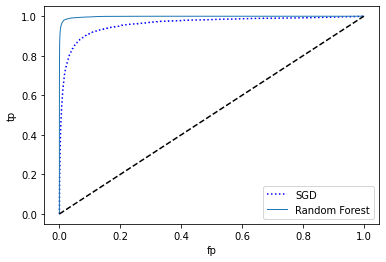

In [54]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [55]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145